In [1]:
# import basic modules
import os, glob, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pysam

# define utils function
def get_complement(seq):
    dict_ = {"A":"T", "T":"A", "G":"C", "C":"G"}
    complement = [dict_[base] for base in seq]
    return complement

In [12]:
# define results folder and print files
results_folder = "/lustre/bio_running/DNA_Ribo_random_2023/results/basecalling_features_with_raw_data"
ref_filepath = "/lustre/bio_running/DNA_Ribo/refs/ref.fa"

Checks sums of differences:
4991   -1.127570e-17
4992    1.890849e-16
4993    1.804112e-16
4994    3.122502e-17
4995   -9.454243e-17
4996    6.245005e-17
4997    1.387779e-16
4998   -1.838807e-16
4999   -1.812786e-16
5000    6.635317e-17
5001   -1.006140e-16
dtype: float64
Some checks...
Rev mean:
 A      0.002491
G     -0.008678
C     -0.018540
T      0.013551
del    0.007936
ins    0.003240
dtype: float64
Saving figure to: /lustre/bio_running/DNA_Ribo_random_2023/results/basecalling_features_with_raw_data/LINEPLOT_DIFF_iForest_CTRL_RIBO1C_DNA-only_vs_RIBO1C
M13mp18:4991-5001_SCALE1.tiff


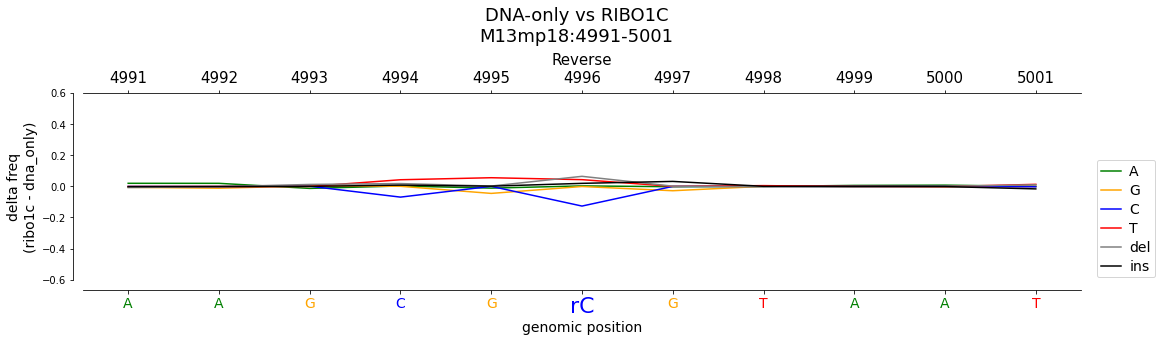

In [43]:
# load control region reverse
dna_rev = pd.read_table("/lustre/bio_running/DNA_Ribo_2023/results/basecalling_features_with_raw_data/DNA only vs RIBO1C site - Whole Primer region.dna.rev.tsv",
                        index_col=0)

# load ribo1c region reverse
ribo_rev = pd.read_table("/lustre/bio_running/DNA_Ribo_2023/results/basecalling_features_with_raw_data/DNA only vs RIBO1C site - Whole Primer region.ribo1c.rev.tsv",
                         index_col=0)

# change to reverse strand frequencies
columns_rev = ['T_count', 'C_count', 'G_count', 'A_count', 'del_count', 'ins_count', 'A', 'G', 'C', 'T', 'del', 'ins']
dna_rev.columns = columns_rev
ribo_rev.columns = columns_rev

# define inputs tsv tables with alignment profiles and basecalling features
dna_sample_name="DNA-only"
ribo_sample_name="RIBO1C"

# define expected sites with ribonucleotides insertion on reverse strand
sites = [4996]
# define ribo names
ribos = ["rC"]
# define color code
color_code = {"A":"green", "G":"orange", "C":"blue", "T":"red", "rA":"green", "rG":"orange", "rC":"blue", "U":"red", "ins":"black", "del":"gray"}

ref = pysam.FastaFile(ref_filepath)

# calculate differential frequencies between dna_only and ribo runs
rev_freqs_diffs = (ribo_rev.iloc[:,-6:].loc[sites[0]-5:sites[0]+5] - dna_rev.iloc[:,-6:].loc[sites[0]-5:sites[0]+5])

# retrieve reference sequences
start, stop = rev_freqs_diffs.index.min()-1, rev_freqs_diffs.index.max()
seq = ref.fetch("M13mp18", start, stop)
seq_rev_compl = get_complement(seq)

# convert to lists
seq = list(seq)
seq_rev_compl = list(seq_rev_compl)

# some checks
print("Checks sums of differences:")
print(rev_freqs_diffs.sum(axis=1))

# take maximum absolute values of differences in both strand to be used to determine y intervals into plots
# to note: poss columns have to be excluded
max_abs_freq  = max(rev_freqs_diffs.abs().max().max(), rev_freqs_diffs.abs().max().max())
if max_abs_freq < 0.6:
    max_abs_freq = 0.6

# some cheks
print("Some checks...")
print("Rev mean:\n", rev_freqs_diffs.mean())

### plot differential alignment profiles
# create a subplot for each site
f, axes = plt.subplots(1, figsize=(15,4), constrained_layout=True)

# plot reverse strand (REVERSE)
# change index labels
rev_freqs_diffs["seq"] = seq_rev_compl
# change seq_rev_compl in agree with ribonucleotides incorporation sites
for s_,r_ in zip(sites,ribos):
    rev_freqs_diffs.loc[s_,"seq"] = r_
# change index to bases and removing its name
rev_freqs_diffs.set_index("seq", inplace=True)
rev_freqs_diffs.index.name = None
# plot
rev_freqs_diffs.plot(ax=axes, color=[color_code[i] for i in rev_freqs_diffs.columns])
axes.set_title("Reverse", fontdict={'fontsize':15})
axes.set_ylim([-max_abs_freq, max_abs_freq])
axes.legend().set_visible(False)
# Move left and bottom spines outward by 10 points
axes.spines.left.set_position(('outward', 10))
axes.spines.bottom.set_position(('outward', 10))
# Hide the right and top spines
axes.spines.right.set_visible(False)
axes.spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
axes.yaxis.set_ticks_position('left')
axes.xaxis.set_ticks_position('bottom')
axes.set_xlabel("genomic position", fontdict={'fontsize':14})
axes.set_ylabel("delta freq\n(ribo1c - dna_only)", fontdict={'fontsize':14})

# change tick colors and sizes
axes.set_xticks(range(len(rev_freqs_diffs.index)))
axes.set_xticklabels(rev_freqs_diffs.index)
my_colors = [color_code[base] for base in seq_rev_compl]
for ticklabel, tickcolor in zip(axes.get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
    ticklabel.set_size(14)
    if ticklabel.get_text() in ribos:
        ticklabel.set_size(22)
        ticklabel.set_text("r"+ticklabel.get_text())

# set second xaxis
secax = axes.secondary_xaxis("top")
secax_labels = [f"{x}" for x in range(start+1,stop+1)]
secax.set_xticks([i for i in range(len(secax_labels))])
secax.set_xticklabels(secax_labels, fontsize=15)

# set suptitle and legend position
suptitle = f"{dna_sample_name} vs {ribo_sample_name}\nM13mp18:{4996-5}-{4996+5}"
f.suptitle(suptitle, x=0.53, y=1.15, fontsize=18)

# change legend labels and colors
handles, labels = axes.get_legend_handles_labels()
l = f.legend(handles, labels, bbox_to_anchor=(1.07, 0.635))
for text, col in zip(l.get_texts(), l.legendHandles):
    col.set_color(color_code[text.get_text()])
    text.set_fontsize(14)

# save image to disk
save_path = os.path.join("/lustre/bio_running/DNA_Ribo_random_2023/results/basecalling_features_with_raw_data/",
                         f"LINEPLOT_DIFF_iForest_CTRL_RIBO1C_{suptitle.replace(chr(92), '_').replace(' ', '_')}_SCALE1.tiff")
print(f"Saving figure to: {save_path}")

plt.savefig(save_path, 
            dpi=300, bbox_inches='tight', facecolor='white', transparent=False)

# plot resulting image
plt.show()

# close reference file
ref.close()

Saving figure to: /lustre/bio_running/DNA_Ribo_random_2023/results/basecalling_features_with_raw_data/LINEPLOT_DIFF_iForest_CTRL_RIBO1C_DNA-only_vs_RIBO1C
M13mp18:4991-5001_SCALE2.tiff


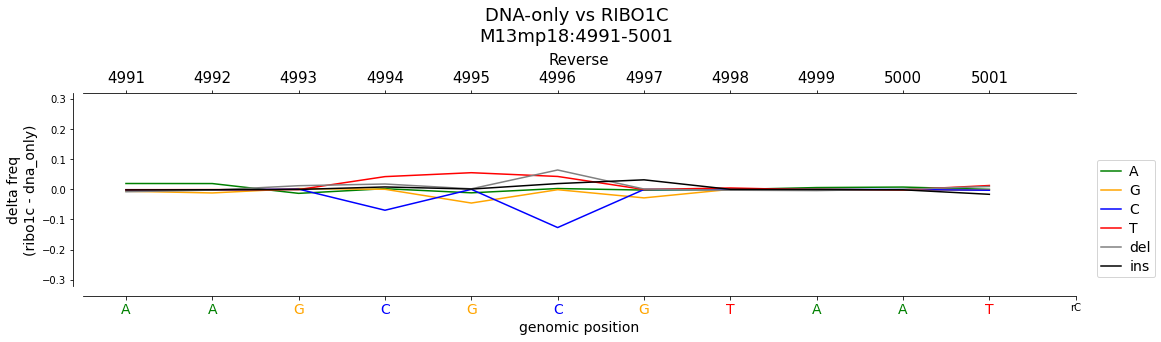

In [44]:
### sCALE 2
# take maximum absolute values of differences in both strand to be used to determine y intervals into plots
# to note: poss columns have to be excluded
max_abs_freq  = max(rev_freqs_diffs.abs().max().max(), rev_freqs_diffs.abs().max().max())
if max_abs_freq < 0.32:
    max_abs_freq = 0.32

### plot differential alignment profiles
# create a subplot for each site
f, axes = plt.subplots(1, figsize=(15,4), constrained_layout=True)

# plot reverse strand (REVERSE)
# change index labels
rev_freqs_diffs["seq"] = seq_rev_compl
# change seq_rev_compl in agree with ribonucleotides incorporation sites
for s_,r_ in zip(sites,ribos):
    rev_freqs_diffs.loc[s_,"seq"] = r_
# change index to bases and removing its name
rev_freqs_diffs.set_index("seq", inplace=True)
rev_freqs_diffs.index.name = None
# plot
rev_freqs_diffs.plot(ax=axes, color=[color_code[i] for i in rev_freqs_diffs.columns])
axes.set_title("Reverse", fontdict={'fontsize':15})
axes.set_ylim([-max_abs_freq, max_abs_freq])
axes.legend().set_visible(False)
# Move left and bottom spines outward by 10 points
axes.spines.left.set_position(('outward', 10))
axes.spines.bottom.set_position(('outward', 10))
# Hide the right and top spines
axes.spines.right.set_visible(False)
axes.spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
axes.yaxis.set_ticks_position('left')
axes.xaxis.set_ticks_position('bottom')
axes.set_xlabel("genomic position", fontdict={'fontsize':14})
axes.set_ylabel("delta freq\n(ribo1c - dna_only)", fontdict={'fontsize':14})

# change tick colors and sizes
axes.set_xticks(range(len(rev_freqs_diffs.index)))
axes.set_xticklabels(rev_freqs_diffs.index)
my_colors = [color_code[base] for base in seq_rev_compl]
for ticklabel, tickcolor in zip(axes.get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
    ticklabel.set_size(14)
    if ticklabel.get_text() in ribos:
        ticklabel.set_size(22)
        ticklabel.set_text("r"+ticklabel.get_text())

# set second xaxis
secax = axes.secondary_xaxis("top")
secax_labels = [f"{x}" for x in range(start+1,stop+1)]
secax.set_xticks([i for i in range(len(secax_labels))])
secax.set_xticklabels(secax_labels, fontsize=15)

# set suptitle and legend position
suptitle = f"{dna_sample_name} vs {ribo_sample_name}\nM13mp18:{4996-5}-{4996+5}"
f.suptitle(suptitle, x=0.53, y=1.15, fontsize=18)

# change legend labels and colors
handles, labels = axes.get_legend_handles_labels()
l = f.legend(handles, labels, bbox_to_anchor=(1.07, 0.635))
for text, col in zip(l.get_texts(), l.legendHandles):
    col.set_color(color_code[text.get_text()])
    text.set_fontsize(14)

# save image to disk
save_path = os.path.join("/lustre/bio_running/DNA_Ribo_random_2023/results/basecalling_features_with_raw_data/",
                         f"LINEPLOT_DIFF_iForest_CTRL_RIBO1C_{suptitle.replace(chr(92), '_').replace(' ', '_')}_SCALE2.tiff")
print(f"Saving figure to: {save_path}")

plt.savefig(save_path, 
            dpi=300, bbox_inches='tight', facecolor='white', transparent=False)

# plot resulting image
plt.show()

# close reference file
ref.close()

In [33]:
rev_freqs_diffs["positions"] = [i for i in range(start+1,stop+1)]
rev_freqs_diffs

,A,G,C,T,del,ins,positions
A,0.019235,-0.006383,-0.001345,-0.001359,-0.008052,-0.002094,4991
A,0.019040,-0.012104,-0.001723,-0.001003,-0.002693,-0.001516,4992
G,-0.013465,0.002400,0.000582,-0.000933,0.011935,-0.000519,4993
C,0.002020,0.000009,-0.069426,0.042053,0.017557,0.007787,4994
G,-0.011689,-0.045554,-0.000157,0.055045,0.001574,0.000781,4995
rC,0.002564,-0.001324,-0.126836,0.042610,0.064037,0.018949,4996
G,-0.002573,-0.028455,-0.000607,-0.000670,0.000897,0.031408,4997
T,-0.000769,-0.000205,-0.000327,0.004424,-0.002982,-0.000141,4998
A,0.005786,0.001414,-0.000288,-0.001977,-0.004223,-0.000711,4999
A,0.007400,-0.003094,-0.000736,-0.001754,-0.000130,-0.001686,5000
